In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
import lightgbm as lgb
from copy import deepcopy
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv('../Base_Umbilo_Diaria.csv', sep=';',decimal=',')
df.set_index('Dia', inplace=True)

df

,Q_entrada,NH_entrada,TSS_entrada,DQO_entrada,DBO_entrada,TN_entrada,TKN_entrada,TP_entrada,PO_entrada,Q_saida,NH_saida,NO_saida,TSS_saida,DQO_saida,DBO_saida,TN_saida,TKN_saida,TP_saida,PO_saida
Dia,,,,,,,,,,,,,,,,,,,
0,4719.000000,21.000000,271.000000,391.000000,198.575000,34.060000,34.060000,8.020000,4.6,6135.066621,3.854908,0.079306,6.642565,83.782370,3.890641,5.042310,4.963005,0.428499,0.326124
1,5866.458829,22.000327,276.000327,399.999347,203.059809,35.360294,35.360294,8.099990,4.6,5636.285517,0.773286,0.349220,5.766311,62.736147,2.720311,1.978541,1.629322,9.226503,9.141557
2,5358.157069,23.998870,281.996233,406.995103,206.957307,37.558734,37.558734,8.149966,4.6,5128.278103,0.572453,0.692591,5.304955,55.605625,2.376578,2.021954,1.329363,11.651663,11.575981
3,5266.313109,22.999791,278.000209,401.000418,203.710285,36.399787,36.399787,8.109998,4.6,5036.211393,0.386242,1.833623,4.898502,52.867768,2.081922,2.924917,1.091294,12.464589,12.396924
4,6671.931586,21.000432,274.999568,396.999136,201.824410,34.220441,34.220441,8.060004,4.6,6441.737326,0.376058,4.070777,4.788757,51.670731,2.013649,5.128931,1.058154,10.463329,10.398509
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361,5587.915779,22.000000,182.001170,263.000000,134.093479,30.780012,30.780012,6.900000,4.6,5357.809665,0.229408,20.738647,3.517159,35.116708,1.583500,21.428344,0.689698,6.256764,6.209620
362,5984.690649,22.998229,179.999646,259.000354,131.495253,31.668215,31.668215,6.869996,4.6,5754.451216,0.270272,21.514507,3.509423,34.582476,1.606304,22.239991,0.725484,5.447559,5.400288
363,8328.225128,19.001002,177.000334,255.999332,129.609978,27.521002,27.521002,6.830000,4.6,8097.935230,0.336837,19.448765,3.977019,34.977963,1.878834,20.261268,0.812503,4.594725,4.540749


In [3]:
y = df['DQO_saida']
X = df.drop(['DQO_saida',
            'Q_saida',
            'NH_saida',
            'NO_saida',
            'TSS_saida',
            'DBO_saida',
            'TN_saida',
            'TKN_saida',
            'TP_saida',
            'PO_saida',
            'DBO_entrada',
            'DQO_entrada',
            'TKN_entrada',
            'TP_entrada',
            'PO_entrada'], axis=1)

print("X", X.shape)
print("y", y.shape)

X (366, 4)
y (366,)


In [4]:
seed = 42

X_training, X_test, y_training, y_test = train_test_split(X, y, shuffle=False, test_size=0.082) 
print("Test set X", X_test.shape)
print("Test set y", y_test.shape)

Test set X (31, 4)
Test set y (31,)


In [5]:
# y Standardization
# Always use the training data only to build the model, then transform the test based on the training (as if the test were new data)
y_train = np.array(y_training).reshape(len(y_training),1)
y_testing = np.array(y_test).reshape(len(y_test),1)

scalery = StandardScaler().fit(y_train)
normalized_y_train = pd.DataFrame(
    scalery.transform(y_train),
    columns = [y_training.name],
    index = y_training.index
)
normalized_y_train = normalized_y_train.squeeze()

normalized_y_test = pd.DataFrame(
    scalery.transform(y_testing),
    columns = [y_test.name],
    index = y_test.index
)
normalized_y_test = normalized_y_test.squeeze()


# Standardization of predictors (DataFrame X)
scalerX = StandardScaler().fit(X_training)

normalized_x_train = pd.DataFrame(
    scalerX.transform(X_training),
    columns = X_training.columns,
    index = X_training.index
)


normalized_x_test = pd.DataFrame(
    scalerX.transform(X_test),
    columns = X_test.columns,
    index = X_test.index
)

In [6]:
# Multi-layer Perceptron regressor with Grid Search and cross-validation

'''class sklearn.neural_network.MLPRegressor(
hidden_layer_sizes=(100,), activation='relu',*, solver='adam', alpha=0.0001, batch_size='auto',
learning_rate='constant', learning_rate_init=0.001, power_t=0.5, max_iter=200, shuffle=True,
random_state=None, tol=0.0001, verbose=False, warm_start=False, momentum=0.9, 
nesterovs_momentum=True, early_stopping=False, validation_fraction=0.1, beta_1=0.9,
beta_2=0.999, epsilon=1e-08,n_iter_no_change=10, max_fun=15000)
'''

# defining the possible values ​​of parameters to be tested
params = {'hidden_layer_sizes': [(16,16),(50,50),(100,100),(16,16,16),(50,50,50),(32,32,32,32)], 
          'solver': ['adam','lbfgs','sgd'],
          'max_iter' : [500, 10000],
          'learning_rate_init' : [0.0001, 0.001, 0.01],
          'random_state' : [42],
          'tol' : [1e-5],
          'alpha':[0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05] 
          }


mlp_model_cv_gs = MLPRegressor()

grid_search = GridSearchCV(mlp_model_cv_gs, param_grid=params, return_train_score=True, scoring='neg_mean_absolute_percentage_error') #,cv=10

grid_search.fit(normalized_x_train, normalized_y_train)

cv_results = pd.DataFrame(grid_search.cv_results_)

cv_best_params = grid_search.best_params_
print('\n Best hyperparameters:')
print(cv_best_params)


c:\Users\hydro\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\hydro\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\hydro\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\hydro\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the opti


 Best hyperparameters:
{'alpha': 0.05, 'hidden_layer_sizes': (16, 16, 16), 'learning_rate_init': 0.0001, 'max_iter': 500, 'random_state': 42, 'solver': 'adam', 'tol': 1e-05}


c:\Users\hydro\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


In [7]:
# printing the average score on the training bases
print("Average accuracy on train set: {:.3f} +/- {:.3f}".format(cv_results[cv_results.rank_test_score == 1].mean_train_score.values[0],
                                                                     cv_results[cv_results.rank_test_score == 1].std_train_score.values[0]))

# printing the average score on the validation bases
print("Average accuracy on validation set: {:.3f} +/- {:.3f}".format(cv_results[cv_results.rank_test_score == 1].mean_test_score.values[0],
                                                                     cv_results[cv_results.rank_test_score == 1].std_test_score.values[0]))

# configuring the model with the best combination of hyperparameters
mlp_model_cv_gs.set_params(hidden_layer_sizes = cv_best_params['hidden_layer_sizes'],
                           solver = cv_best_params['solver'],
                           verbose = False
                           )

# training a model with the best combination of hyperparameters
mlp_model_cv_gs.fit(normalized_x_train, normalized_y_train)
best_model_params = mlp_model_cv_gs.get_params()

Average accuracy on train set: -1.665 +/- 0.373
Average accuracy on validation set: -1.759 +/- 1.615


In [9]:
# Performing the prediction in the test
y_test_pred_mlp = mlp_model_cv_gs.predict(normalized_x_test)

# De-standardization
y_test_pred_mlp = np.array(y_test_pred_mlp).reshape(len(y_test_pred_mlp),1)
y_test_pred_mlp = scalery.inverse_transform(y_test_pred_mlp)
y_test_pred_mlp = pd.DataFrame(y_test_pred_mlp, columns=[normalized_y_test.name], index = normalized_y_test.index)
y_test_pred_mlp = y_test_pred_mlp.squeeze()

y_test_pred_mlp


# Analysis of forecast errors
rmse_test_mlp = math.sqrt(mean_squared_error(y_test, y_test_pred_mlp))
mae_test_mlp = mean_absolute_error(y_test, y_test_pred_mlp)
mape_test_mlp = mean_absolute_percentage_error(y_test, y_test_pred_mlp)
r2_test_mlp = r2_score(y_test, y_test_pred_mlp)


df_metricas = pd.DataFrame(data={'RSME':[rmse_test_mlp], 'MAE':[mae_test_mlp], 'MAPE':[mape_test_mlp],'R²':[r2_test_mlp]})
df_metricas

,RSME,MAE,MAPE,R²
0,10.660465,8.5258,0.155903,0.869675


In [10]:
# Cross-validation to check the accuracy of the model in the training base
print('---------Treino---------')
results = cross_val_score(mlp_model_cv_gs,X=X_training,y=y_training,cv=KFold(n_splits=10), scoring='neg_mean_absolute_percentage_error')*(-1)
print(results)
print('Média: {}\nStd: {}'.format(round(results.mean(),4),round(results.std(),4)))
print('---------Total---------')

results_total = cross_val_score(mlp_model_cv_gs,X=X,y=y,cv=KFold(n_splits=10), scoring='neg_mean_absolute_percentage_error')*(-1)
print(results_total)
print('Média: {}\nStd: {}'.format(round(results_total.mean(),4),round(results_total.std(),4)))

---------Treino---------


c:\Users\hydro\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[0.229608   0.73988459 0.43254848 0.40228545 0.67853961 0.39708247
 0.18608341 0.19872834 0.28637092 0.20599549]
Média: 0.3757
Std: 0.1882
---------Total---------


c:\Users\hydro\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\hydro\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[0.26307964 0.3086083  0.20366004 0.16724648 0.1125128  0.15680773
 0.25623068 0.18458932 0.19656468 1.21428597]
Média: 0.3064
Std: 0.3075


c:\Users\hydro\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\hydro\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [11]:
# Preparation of the comparative DataFrame between the forecast and the actual value, indexed by day
y_test_pred_df = pd.Series(y_test_pred_mlp,index=y_test.index)
df_comparacao = pd.concat([y_test,y_test_pred_df],axis=1)
df_comparacao.columns = ['Valor_Real','Valor_Predito']
df_comparacao['Diferenca_percentual'] = 100*(df_comparacao['Valor_Predito'] - df_comparacao['Valor_Real'])/df_comparacao['Valor_Real']
df_comparacao.sort_index(inplace=True)
df_comparacao

,Valor_Real,Valor_Predito,Diferenca_percentual
Dia,,,
335,83.784619,79.071087,-5.625773
336,86.842041,105.495400,21.479640
337,119.987156,133.630187,11.370410
338,138.940253,117.454553,-15.463986
339,126.281606,110.033388,-12.866654
340,112.852382,113.050442,0.175504
341,113.403341,113.328386,-0.066096
342,94.146869,80.119053,-14.899928
343,86.724664,104.472472,20.464545


        RSME     MAE      MAPE        R²
0  10.660465  8.5258  0.155903  0.869675


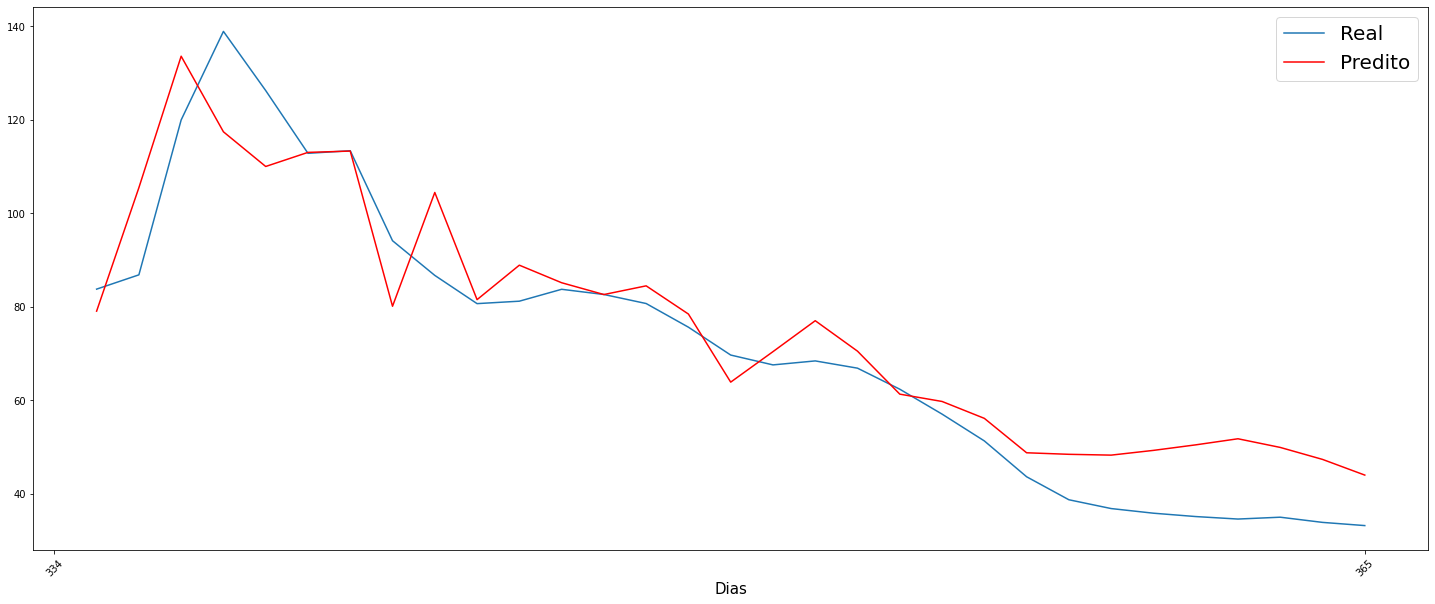

In [12]:
print(df_metricas)
import matplotlib.dates as mdates
# Graphic visualization of predictions compared to actual values
fig = plt.figure(figsize=(25,10))
ax = fig.add_subplot(1,1,1) 
# plt.title('', fontsize=25)
plt.plot(df_comparacao.index, df_comparacao['Valor_Real'], label = 'Real')
plt.plot(df_comparacao.index, df_comparacao['Valor_Predito'], label = 'Predito', c='r')
plt.legend(fontsize=20)
plt.xlabel('Dias', fontsize=15)
plt.xticks(fontsize=10, rotation=45)

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1)) 
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%M-%d'))

plt.show()

In [13]:
# Saving predictions

df_comparacao.to_csv("1_3-Previsoes_MLP.csv", encoding='utf-8-sig',sep=';',decimal=',')

# Forecast on training basis

        RSME        MAE      MAPE        R²
0  22.084385  14.503918  0.136035  0.671631


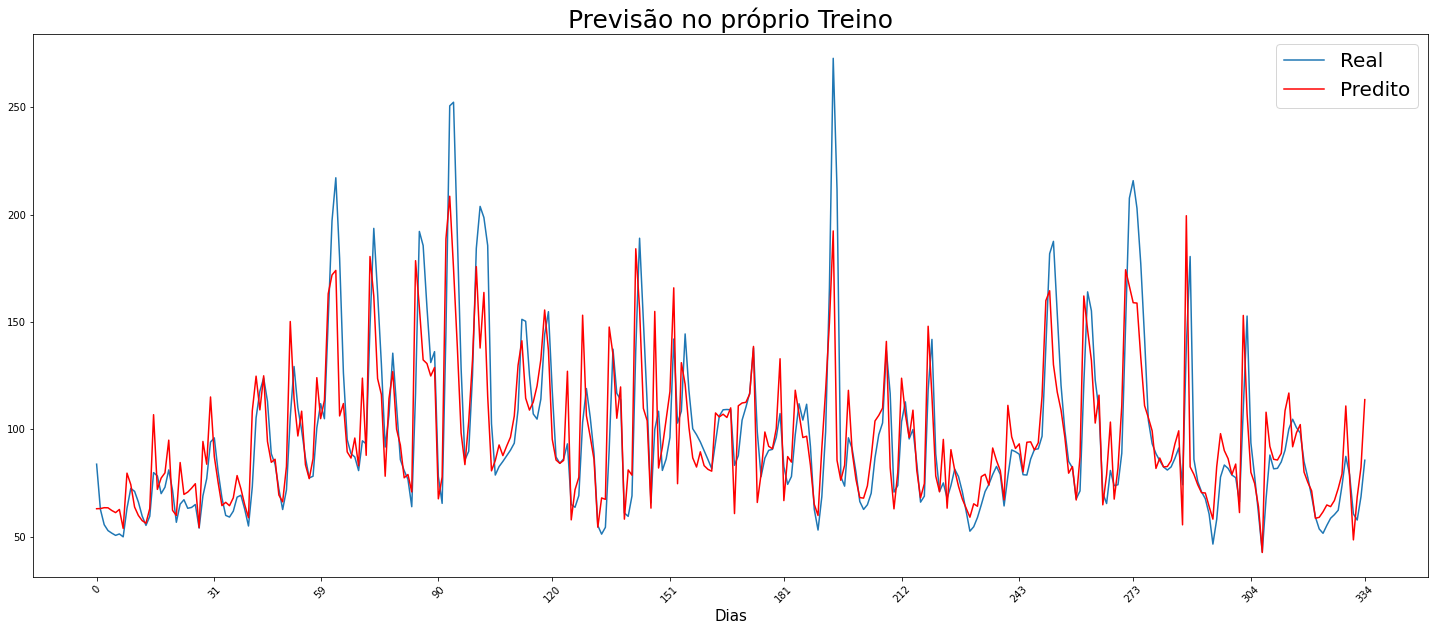

In [14]:
y_train_pred_mlp = mlp_model_cv_gs.predict(normalized_x_train)

y_train_pred_mlp = np.array(y_train_pred_mlp).reshape(len(y_train_pred_mlp),1)
y_train_pred_mlp = scalery.inverse_transform(y_train_pred_mlp)
y_train_pred_mlp = pd.DataFrame(y_train_pred_mlp, columns=[normalized_y_train.name], index = normalized_y_train.index)
y_train_pred_mlp = y_train_pred_mlp.squeeze()

y_train_pred_mlp


rmse_train_mlp = math.sqrt(mean_squared_error(y_train, y_train_pred_mlp))
mae_train_mlp = mean_absolute_error(y_train, y_train_pred_mlp)
mape_train_mlp = mean_absolute_percentage_error(y_train, y_train_pred_mlp)
r2_train_mlp = r2_score(y_train, y_train_pred_mlp)

df_train_comparacao = pd.concat([y_training,y_train_pred_mlp],axis=1)
df_train_comparacao.columns = ['Valor_Real','Valor_Predito']
df_train_comparacao['Diferenca_percentual'] = 100*(df_train_comparacao['Valor_Predito'] - df_train_comparacao['Valor_Real'])/df_train_comparacao['Valor_Real']
df_train_comparacao.sort_index(inplace=True)
df_train_comparacao


df_train_metricas = pd.DataFrame(data={'RSME':[rmse_train_mlp], 'MAE':[mae_train_mlp], 'MAPE':[mape_train_mlp],'R²':[r2_train_mlp]})
print(df_train_metricas)


fig = plt.figure(figsize=(25,10))
ax = fig.add_subplot(1,1,1) 
plt.title('Previsão no próprio Treino', fontsize=25)
plt.plot(df_train_comparacao.index, df_train_comparacao['Valor_Real'], label = 'Real')
plt.plot(df_train_comparacao.index, df_train_comparacao['Valor_Predito'], label = 'Predito', c='r')
plt.legend(fontsize=20)
plt.xlabel('Dias', fontsize=15)
plt.xticks(fontsize=10, rotation=45)

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1)) 
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%M-%d'))

plt.show()

In [15]:
df_train_comparacao.to_csv('2_3-Previsoes_TREINO_MLP.csv',sep=';',decimal=',',encoding='utf-8-sig')

# FEATURE IMPORTANCE

## PDPs and Permutation Importance

In [16]:
print(normalized_x_train.min())
print(normalized_x_train.max())

Q_entrada     -2.727095
NH_entrada    -2.605314
TSS_entrada   -2.494750
TN_entrada    -2.588871
dtype: float64
Q_entrada      2.838441
NH_entrada     6.840331
TSS_entrada    4.629701
TN_entrada     4.368140
dtype: float64


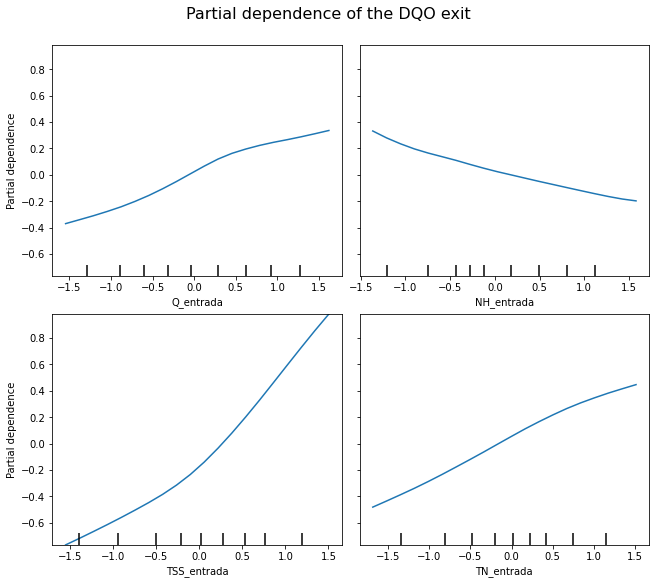

In [17]:
from sklearn.inspection import PartialDependenceDisplay

common_params = {
    "subsample": 50,
    "n_jobs": 2,
    "grid_resolution": 20,
    "random_state": 0,
}

# print("Computing partial dependence plots...")
features_info = {
    # features of interest
    "features": X_training.columns,
    # type of partial dependence plot
    "kind": "average",
    # information regarding categorical features
    # "categorical_features": categorical_features,
}

_, ax = plt.subplots(ncols=2, nrows=2, figsize=(9, 8), constrained_layout=True)
display = PartialDependenceDisplay.from_estimator(
    mlp_model_cv_gs,
    normalized_x_train,
    **features_info,
    ax=ax,
    **common_params,
)

_ = display.figure_.suptitle(
    "Partial dependence of the DQO exit\n",
    fontsize=16,
)

,Importance_mean,Importance_std,Importance_mean_normalized
TSS_entrada,0.739298,0.082107,0.571519
TN_entrada,0.223735,0.028732,0.172960
Q_entrada,0.213859,0.034901,0.165325
NH_entrada,0.116676,0.023416,0.090197


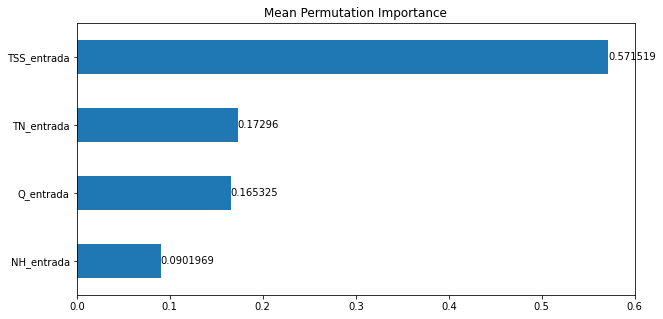

In [18]:
from sklearn.inspection import permutation_importance
r = permutation_importance(mlp_model_cv_gs, normalized_x_train, normalized_y_train,
                           n_repeats=30,
                           random_state=0)
# r.importances_mean
# r.importances_std

df_permutation_importance = pd.DataFrame(
    data={'Importance_mean': r.importances_mean,
          'Importance_std': r.importances_std},
    index=normalized_x_train.columns
)

df_permutation_importance['Importance_mean_normalized'] = df_permutation_importance['Importance_mean']/df_permutation_importance['Importance_mean'].sum()

df_permutation_importance = df_permutation_importance.sort_values('Importance_mean',ascending=False)

ax = df_permutation_importance['Importance_mean_normalized'].sort_values(ascending=True).plot.barh(figsize=(10,5), title='Mean Permutation Importance')
ax.bar_label(ax.containers[0])

df_permutation_importance

In [19]:
df_permutation_importance.to_csv('3_3-Permutation_Importance_MLP.csv',sep=';',decimal=',',encoding='utf-8-sig')

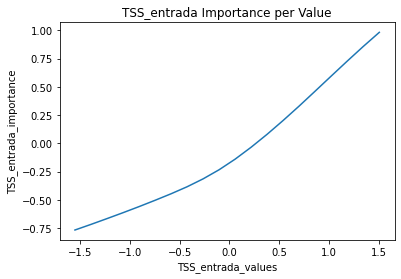

,Q_entrada_importance,Q_entrada_values,NH_entrada_importance,NH_entrada_values,TSS_entrada_importance,TSS_entrada_values,TN_entrada_importance,TN_entrada_values
0,-0.370065,-1.545764,0.331970,-1.365209,-0.767760,-1.551337,-0.481472,-1.681477
1,-0.340456,-1.379149,0.279469,-1.210232,-0.718115,-1.390468,-0.435015,-1.513572
2,-0.310454,-1.212533,0.234926,-1.055255,-0.666824,-1.229599,-0.387606,-1.345666
3,-0.277912,-1.045917,0.196296,-0.900279,-0.614558,-1.068730,-0.338932,-1.177761
4,-0.242646,-0.879302,0.164747,-0.745302,-0.560651,-0.907861,-0.287619,-1.009856
5,-0.201977,-0.712686,0.137290,-0.590325,-0.504796,-0.746992,-0.233910,-0.841950
6,-0.156839,-0.546070,0.109645,-0.435349,-0.446995,-0.586123,-0.178089,-0.674045
7,-0.105977,-0.379454,0.079223,-0.280372,-0.384946,-0.425254,-0.121596,-0.506140
8,-0.050926,-0.212839,0.050166,-0.125395,-0.314960,-0.264385,-0.063940,-0.338234
9,0.007284,-0.046223,0.023248,0.029582,-0.234182,-0.103516,-0.004704,-0.170329


In [20]:
dict_data = {}
df_pdp = pd.DataFrame(display.pd_results[0]['average'].flatten(),columns=[X.columns[0]+'_importance'])
for i in range(len(display.pd_results)):
    dict_data[f"{X.columns[i]}_importance"] = display.pd_results[i]['average']
    dict_data[f"{X.columns[i]}_values"]  = display.pd_results[i]['values']
    # df_pdp[f"{X.columns[i]}_importance"] = dict_data[f"{X.columns[i]}_importance"].flatten()
    df_pdp[f"{X.columns[i]}_importance"] = display.pd_results[i]['average'][0]
    df_pdp[f"{X.columns[i]}_values"] = display.pd_results[i]['values'][0]


plt.plot(df_pdp.loc[:, 'TSS_entrada_values'], df_pdp.loc[:, 'TSS_entrada_importance'])
plt.xlabel('TSS_entrada_values')
plt.ylabel('TSS_entrada_importance')
plt.title('TSS_entrada Importance per Value')
plt.show()


df_pdp.to_csv('4_3-PDPs_MLP.csv',encoding='utf-8-sig',decimal=',',sep=';')
df_pdp

In [21]:
# Evaluating on TEST dataset the impact on the metrics caused by the permutation of values ​​of each of the variables.
# https://scikit-learn.org/stable/modules/permutation_importance.html#permutation-importance
scoring = ['r2', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error']
r_multi = permutation_importance(
    mlp_model_cv_gs, normalized_x_test, normalized_y_test, n_repeats=30, random_state=0, scoring=scoring)

# Only show variables whose importance is greater than 2 times the respective standard deviation (for all metrics)
for metric in r_multi:
    print(f"{metric}")
    r1 = r_multi[metric]
    for i in r1.importances_mean.argsort()[::-1]:
        if r1.importances_mean[i] - 2 * r1.importances_std[i] > 0:
            print(f"    {X.columns[i]}: "
                  f"{r1.importances_mean[i]:.3f}"
                  f" +/- {r1.importances_std[i]:.3f}\n")

r2
    TSS_entrada: 0.891 +/- 0.187

    TN_entrada: 0.399 +/- 0.095

    NH_entrada: 0.103 +/- 0.033

neg_mean_absolute_percentage_error
    TSS_entrada: 0.663 +/- 0.170

    TN_entrada: 0.282 +/- 0.091

    NH_entrada: 0.127 +/- 0.057

neg_mean_squared_error
    TSS_entrada: 0.523 +/- 0.110

    TN_entrada: 0.234 +/- 0.056

    NH_entrada: 0.061 +/- 0.020



In [22]:
# Evaluating the impact on the metrics caused by the permutation of values ​​of each of the variables on TRAINING dataset.
# https://scikit-learn.org/stable/modules/permutation_importance.html#permutation-importance
scoring = ['r2', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error'] #, 'neg_mean_absolute_error'
r_multi = permutation_importance(
    mlp_model_cv_gs, normalized_x_train, normalized_y_train, n_repeats=30, random_state=0, scoring=scoring)

# Only show variables whose importance is greater than 2 times the respective standard deviation (for all metrics)
for metric in r_multi:
    print(f"{metric}")
    r1 = r_multi[metric]
    for i in r1.importances_mean.argsort()[::-1]:
        if r1.importances_mean[i] - 2 * r1.importances_std[i] > 0:
            print(f"    {X.columns[i]}: "
                  f"{r1.importances_mean[i]:.3f}"
                  f" +/- {r1.importances_std[i]:.3f}")

r2
    TSS_entrada: 0.739 +/- 0.082
    TN_entrada: 0.224 +/- 0.029
    Q_entrada: 0.214 +/- 0.035
    NH_entrada: 0.117 +/- 0.023
neg_mean_absolute_percentage_error
    Q_entrada: 0.861 +/- 0.410
    TSS_entrada: 0.804 +/- 0.313
    NH_entrada: 0.470 +/- 0.214
neg_mean_squared_error
    TSS_entrada: 0.739 +/- 0.082
    TN_entrada: 0.224 +/- 0.029
    Q_entrada: 0.214 +/- 0.035
    NH_entrada: 0.117 +/- 0.023


## LIME - Local Interpretable Model-Agnostic Explanations 

In [23]:
# import lime
# import lime.lime_tabular

# # LIME has one explainer for all the models
# explainer = lime.lime_tabular.LimeTabularExplainer(normalized_x_train.values, feature_names=X.columns.values.tolist(),
#                                                   class_names=[y.name], verbose=True, mode='regression')

### Calculation of the importance of each variable for a specific record

In [24]:
# # normalized_x_test.iloc[5]
# # normalized_x_test.values[5]

# # Choose the 5th instance and use it to predict the results
# j = 5
# exp = explainer.explain_instance(normalized_x_test.iloc[j], mlp_model_cv_gs.predict, num_features=4)

# # Show the predictions
# exp.show_in_notebook(show_table=True)

# exp.as_list()

Interpretation: The Predicted value is the center of the first image (Predicted value).
The variables on the left had a negative influence on the predicted value, while the variables on the right had a positive influence.
List of Features with the respective values ​​fed to the prediction.

In [25]:
# # Choose the 10th instance and use it to predict the results
# j = 10
# exp = explainer.explain_instance(normalized_x_test.iloc[j], mlp_model_cv_gs.predict, num_features=6)

# # Show the predictions
# exp.show_in_notebook(show_table=True)

# exp.as_list()

In [26]:
# # Choose the LAST instance and use it to predict the results
# j = -1
# exp = explainer.explain_instance(normalized_x_test.iloc[j], mlp_model_cv_gs.predict, num_features=6)

# # Show the predictions
# exp.show_in_notebook(show_table=True)

# exp.as_list()

In [27]:
# # Apply lime to last 20 observations
# from interpret.blackbox import LimeTabular
# from interpret import show


# # Initilize Lime for Tabular data
# lime = LimeTabular(model=mlp_model_cv_gs, 
#                    data=normalized_x_train, 
#                    random_state=1)
# # Get local explanations
# lime_local = lime.explain_local(normalized_x_test, 
#                                 normalized_y_test, 
#                                 name='LIME')

# show(lime_local)

### Overall Feature Importance analysis with LIME instead of just for specific occurrence

In [28]:
# import warnings
# warnings.filterwarnings("ignore")

# import re
# l=[]
# for n in range(0,normalized_x_test.shape[0]):
#      exp = explainer.explain_instance(normalized_x_test.values[n], mlp_model_cv_gs.predict, num_features=X.shape[1])
#      a=exp.as_list()
#      l.append(a)


# df_lime_importances = pd.DataFrame()
# for sublist in l:
#     row_values = {}
#     for condition, value in sublist:
#         match = re.search(r'([a-zA-Z_]+)', condition)
#         if match:
#             text = match.group(1)        
#             row_values[text] = value
#     df_lime_importances = df_lime_importances.append(row_values, ignore_index=True)

# df_lime_importances

In [29]:
# df_lime_absolute_importances = df_lime_importances.copy()

# for i in range(df_lime_importances.shape[1]):
#     df_lime_absolute_importances.iloc[:,i] = df_lime_absolute_importances.iloc[:,i].apply(lambda x: abs(float(x)))
     
# df_lime_absolute_importances.head()

In [30]:
# df_lime_absolute_importances.mean()/df_lime_absolute_importances.mean().sum()

In [31]:
# # df_lime_importances['TN'].plot()
# df_lime_importances.plot()
# df_lime_absolute_importances.plot()

### Overall Feature Importance analysis with LIME rather than just for specific occurrence for TRAINING Dataset

In [32]:
# l=[]
# for n in range(0,normalized_x_train.shape[0]):
#      exp = explainer.explain_instance(normalized_x_train.values[n], mlp_model_cv_gs.predict, num_features=X.shape[1])
#      a=exp.as_list()
#      l.append(a)


# df_lime_train_importances = pd.DataFrame()
# for sublist in l:
#     row_values = {}
#     for condition, value in sublist:
#         match = re.search(r'([a-zA-Z_]+)', condition)
#         if match:
#             text = match.group(1)        
#             row_values[text] = value
#     df_lime_train_importances = df_lime_train_importances.append(row_values, ignore_index=True)

# df_lime_train_importances

In [33]:
# df_lime_train_absolute_importances = df_lime_train_importances.copy()

# for i in range(df_lime_importances.shape[1]):
#     df_lime_train_absolute_importances.iloc[:,i] = df_lime_train_absolute_importances.iloc[:,i].apply(lambda x: abs(float(x)))
     
# df_lime_train_absolute_importances

In [34]:
# df_lime_train_absolute_importances.mean()/df_lime_train_absolute_importances.mean().sum()

In [35]:
# # df_lime_train_importances['TN'].plot()
# df_lime_train_importances.plot()
# df_lime_train_absolute_importances.plot()

In [36]:
# Saving predictions

# df_comparacao.to_csv("Previsoes_RF.csv", encoding='utf-8-sig',sep=';',decimal=',')